# Data set Description

This data set contains a set of bed-posture data, which were recollected in the paper: __[A Pressure Map Data set for In-bed Posture Classification](https://physionet.org/content/pmd/1.0.0/)__. There are a total of 13 individuals. For each one, a record have been done using a sensor. This sensor measured the pressure in a 32 * 64 mat. Also, the total record time per each individual was set to 2 minutes. The sensor recorded a total of 17 positions. These positions are: _supine, left, right, and fetus (right, left)_. In this analysis, we use a total of three postures, where left and right fetus are also considered as: _right_ and _left_.

## Download the data set

First, we will download the data set.

In [1]:
!wget https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!unzip -q a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
!mv a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0 dataset 

--2019-08-13 16:26:24--  https://physionet.org/static/published-projects/pmd/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip
wget: /home/antonio/.netrc:4: unknown token "method"
wget: /home/antonio/.netrc:4: unknown token "interactive"
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107315828 (102M) [application/zip]
Saving to: ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip.2’

a-pressure-map-data 100%[===================>] 102.34M  2.64MB/s    in 39s     

2019-08-13 16:27:04 (2.62 MB/s) - ‘a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0.zip.2’ saved [107315828/107315828]

mv: cannot move 'a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0' to 'dataset/a-pressure-map-dataset-for-in-bed-posture-classification-1.0.0': Directory not empty


We now have a folder called __dataset__, which contains two experiments. In the following sections, we will focus on experiment I.

# Libraries

In [1]:
import numpy as np
import os
from itertools import islice
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(123)

In [3]:
%matplotlib inline

# Functions

In [4]:
def plot_losses(train_losses, test_losses, n_epochs):
    import seaborn as sns
    sns.set()
    plt.plot(range(n_epochs), train_losses)
    plt.plot(range(n_epochs), test_losses)
    plt.title('Train vs Test loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(['train', 'test'])
    plt.show()

In [5]:
def load_data01(path):
    """
    Creates a numpy array for the data and labels.
    
    params:
    ------
    path    -- Data path.
    
    returns:
    -------
    A numpy array (data, labels).
    """
    Normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()])
    
    subjects_dict = {}
    positions = ["justAPlaceholder","supine", "right", "left", "right", "right", "left", "left", 
                 "supine", "supine", "supine", "supine", "supine", "right", "left", "supine", "supine", 
                 "supine"]
    for _, dirs, _ in os.walk(path):
        for directory in dirs:
            # each directory is a subject
            subject = directory
            data = None
            labels = None
            for _, _, files in os.walk(os.path.join(path, directory)):
                for file in files:
                    file_path = os.path.join(path, directory, file)
                    with open(file_path, 'r') as f:
                        # Start from second recording, as the first two are corrupted
                        for line in f.read().splitlines()[2:]:
                            def token_position(x):
                                return {
                                    'supine': 0,
                                    'left': 1,
                                    'right': 2,
                                    'left_fetus': 1,
                                    'right_fetus': 2
                                }[x]
                            raw_data = np.fromstring(line, dtype=float, sep='\t')
                            file_data = np.round(raw_data*255/1000).astype(np.uint8) # Change the range from [0-1000] to [0-255]. This allows us to use tranforms later.
                            # adding standar normalization
                            file_data = Normalize(file_data.reshape(64,32))
                            file_data = file_data.view(1, 64, 32)
                            ##
                            file_label = token_position(positions[int(file[:-4])]) # Turn the file index into position list, and turn position list into reduced indices.
                            file_label = np.array([file_label])

                            if data is None:
                                data = file_data
                            else:
                                data = np.concatenate((data, file_data), axis=0)
                            if labels is None:
                                labels = file_label
                            else:
                                labels = np.concatenate((labels, file_label), axis=0)

            subjects_dict[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
    return subjects_dict

def load_data02(path):
    positions = {"B":"supine", "1":"supine", "C":"right", "D":"left", "E1":"right", "E2":"right", "E3":"left", "E4":"left",
        "E5":"right", "E6":"left", "F":"supine", "G1":"supine", "G2":"right", "G3":"left"}
    
    def token_position(x):
        return {
            'supine': 0,
            'left': 1,
            'right': 2
        }[x]

    subjects_dict_air = {}
    subjects_dict_spo = {}

    def resize_and_rotate(image):
        To_PIL_and_Resize = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 32)) ])
        
        rotated = TF.rotate(To_PIL_and_Resize(image), angle=180)
        return transforms.ToTensor()(rotated)

    # each directory is a subject
    for _, subject_dirs, _ in os.walk(path):
        for subject in subject_dirs:
            data = None
            labels = None

            # each directory is a matresss
            for _, mat_dirs, _ in os.walk(os.path.join(path, subject)):
                for mat in mat_dirs:
                    for _, _, files in os.walk(os.path.join(path, subject, mat)):
                        for file in files:
                            file_path = os.path.join(path, subject, mat, file)
                            raw_data = np.loadtxt(file_path)
                            file_data = np.round(raw_data*255/500).astype(np.uint8) # Change the range from [0-500] to [0-255]. This allows us to use tranforms later. 
                            file_data = resize_and_rotate(file_data)
                            file_data = file_data.view(1, 64, 32)

                            if file[-6] == "E" or file[-6] == "G":
                                file_label = positions[file[-6:-4]]
                            else:
                                file_label = positions[file[-6]]

                            file_label = token_position(file_label)
                            file_label = np.array([file_label])           

                            if data is None:
                                data = file_data
                            else:
                                data = np.concatenate((data, file_data), axis=0)

                            if labels is None:
                                labels = file_label
                            else:
                                labels = np.concatenate((labels, file_label), axis=0)

                    if mat == "Air_Mat":                        
                        subjects_dict_air[subject] = (torch.from_numpy(data), torch.from_numpy(labels))
                    else:
                        subjects_dict_spo[subject] = (torch.from_numpy(data), torch.from_numpy(labels))

                    data = None
                    labels = None
    return subjects_dict_air, subjects_dict_spo

In [6]:
def create_numpy_data(subjects_dict):
    """
    This function prepares the original data into 
    a flat representation to be used by a shallow
    model.
    """
    # create a single data set
    users = list(subjects_dict.keys())
    # assing data
    data = subjects_dict[users[0]][0]
    labels = subjects_dict[users[0]][1]
    # loop over the users
    for user in users[1:]:
        data = np.append(data, subjects_dict[user][0], axis = 0)
        labels = np.append(labels, subjects_dict[user][1], axis = 0)
        
    return data.reshape(-1, 2048), labels

In [7]:
def plot_data01(user, subjects_dict):
    """
    Plots data from the experiments.
    """
    # read the user
    size = subjects_dict[user][0].shape[0]
    # sample
    sample = np.random.choice(range(0, size), 24, replace = False)
    # data
    data = subjects_dict[user][0].numpy()
    # plots
    f, arr = plt.subplots(3, 8, figsize = (15, 8))
    f.suptitle('Position data for user: {}'.format(user), y = 0.95)
    fig = 0
    for r in range(3):
        for c in range(8):
            arr[r, c].imshow(data[sample[fig]].reshape(64, 32), aspect = 'auto')
            arr[r, c].axis('off')
            fig += 1

def hist_plot01(subjects_dict):
    import seaborn as sns
    sns.set()
    keys = list(subjects_dict.keys())
    data = subjects_dict[keys[0]][1].numpy()
    for x in keys[1:]:
        data = np.append(data, subjects_dict[x][1], axis = 0)
    fig, ax = plt.subplots()
    numbers=[x for x in range(0,3)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(-0.5,3)
    plt.hist(data, bins=np.arange(4)-0.5)
    labels = ['supine', 'left', 'right']
    ax.set_xticklabels(labels)
    plt.title('Histogram plot')
    plt.xlabel('classes')
    plt.ylabel('counts')
    plt.show()

In [8]:
def plot_data02(user, subjects_dict, bed):
    """
    Plots data from the experiments.
    """
    # read the user
    size = subjects_dict[user][0].shape[0]
    # sample
    sample = np.random.choice(range(0, size), 20, replace = False)
    # data
    data = subjects_dict[user][0].numpy()
    # plots
    f, arr = plt.subplots(2, 5, figsize = (15, 8))
    f.suptitle('Position data for user: {} in {}'.format(user, bed), y = 0.95)
    fig = 0
    for r in range(2):
        for c in range(5):
            arr[r, c].imshow(data[sample[fig]].reshape(64, 32), aspect = 'auto')
            arr[r, c].axis('off')
            fig += 1

def hist_plot02(subjects_dict, mat):
    import seaborn as sns
    sns.set()
    keys = list(subjects_dict.keys())
    data = subjects_dict[keys[0]][1].numpy()
    for x in keys[1:]:
        data = np.append(data, subjects_dict[x][1], axis = 0)
    fig, ax = plt.subplots()
    numbers=[x for x in range(0,3)]
    labels=map(lambda x: str(x), numbers)
    plt.xticks(numbers, labels)
    plt.xlim(-0.5,3)
    plt.hist(data, bins=np.arange(4)-0.5)
    labels = ['supine', 'left', 'right']
    ax.set_xticklabels(labels)
    plt.title('Histogram plot for: {}'.format(mat))
    plt.xlabel('classes')
    plt.ylabel('counts')
    plt.show()

In [9]:
def train_model(model, loaders, model_optimizer, criterion, n_epochs, print_epoch=True):
    """
    This function train the model.
    """
    model.train()
    running_loss = 0
    train_losses, test_losses = [], []
    for epoch in range(n_epochs):
        for data, labels in loaders[0]:
            model_optimizer.zero_grad()
            # get predictions
            y_hat = model(data)
            # calculate loss
            loss = criterion(y_hat, labels)
            loss.backward()
            # optimize
            model_optimizer.step()
            # show loss
            running_loss += loss.data.numpy()
        else:
            test_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for inputs, labels in loaders[1]:
                    logps = model(inputs)
                    loss = criterion(logps, labels)
                    test_loss += loss.data.numpy()
        
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.float())
    
            train_losses.append(running_loss/len(loaders[0]))
            test_losses.append(test_loss/len(loaders[1]))
            
        if print_epoch:
            print('Epoch: {}|{} | Training loss: {} | Test loss: {} | Test accuracy: {}'.format(epoch + 1, n_epochs, 
                                                                                                running_loss/len(loaders[0]),
                                                                                               test_loss/len(loaders[1]),
                                                                                                accuracy/len(loaders[1])))
        running_loss = 0
        model.train()
    return model, train_losses, test_losses

# Exploratory Data Analysis

In this section we will apply an EDA over the data set. Since this data set is composed by two separated sets (experiments). We will first focus our analysis in the first set (experiment I). Then we will continue with the secon one (experiment II).

## Experiment I

In [10]:
# set path
path = './dataset/experiment-i/'

In this dataset we have a total of 13 users. For each user a total of 17 txt files contain their bed positions.

In [11]:
# read users
users = users = os.listdir(path)
# remove cvs file
users = users[1:]

In [12]:
# print users
for u in users:
    print(u, end = ' ')

S7 S3 S6 S10 S8 S13 S5 S12 S9 S11 S1 S4 S2 

In [13]:
# load data
subjects_dict = load_data01(path)

As we can see, we have a total of 13 inviduals in the data set. Now, we will explore the data. In particular, since we have a total of 13 inviduals, we will explore each one.

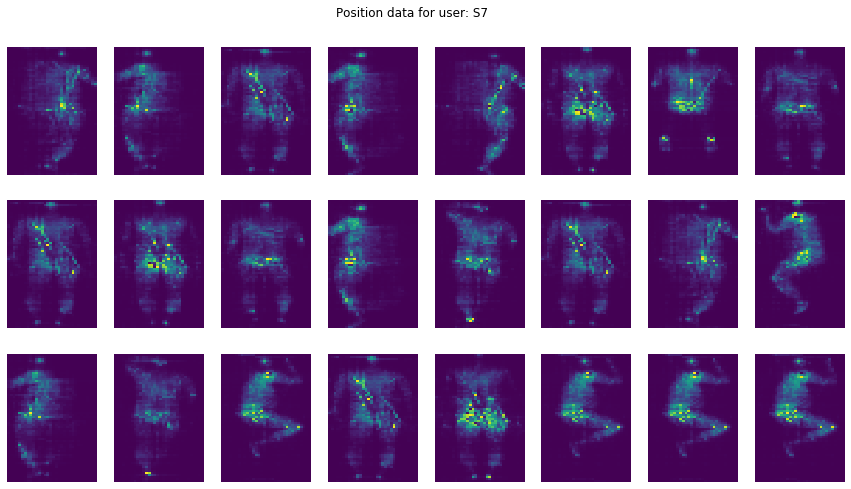

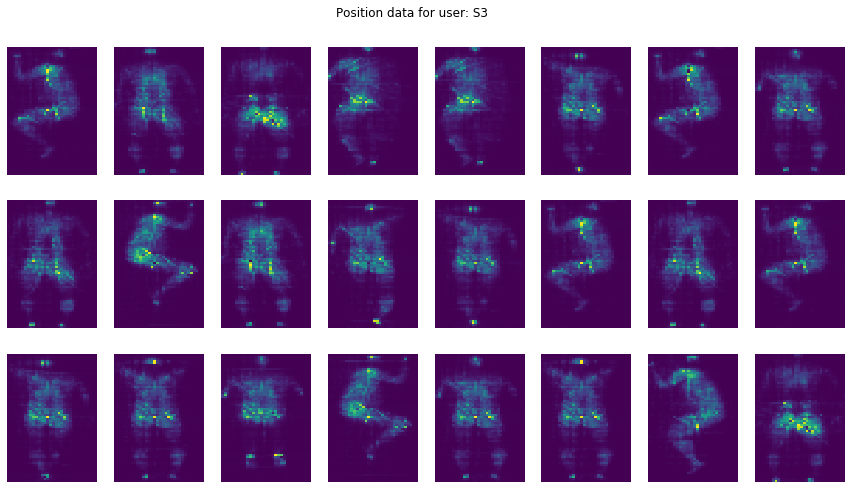

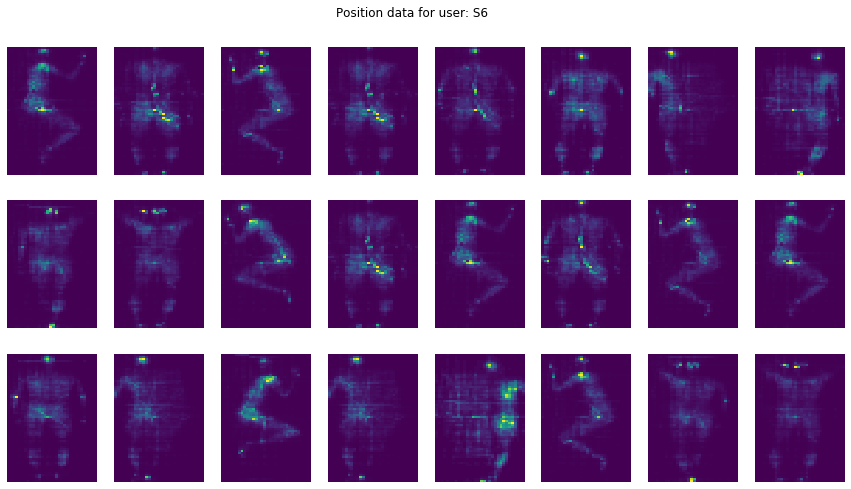

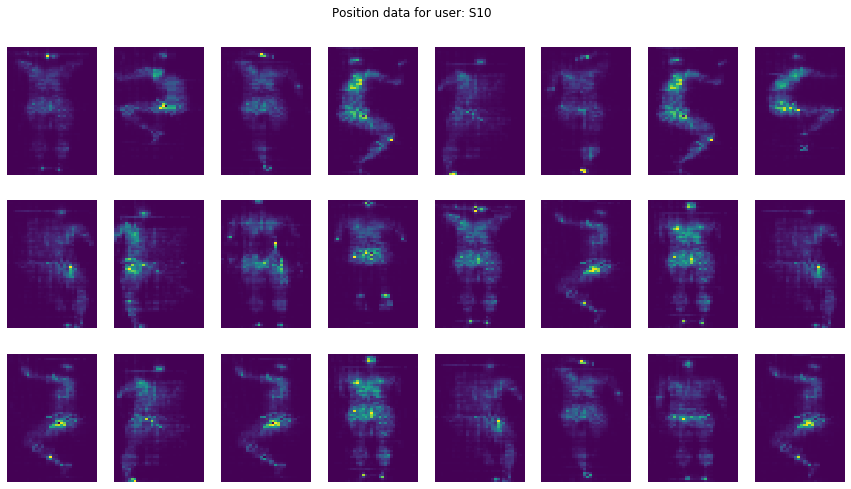

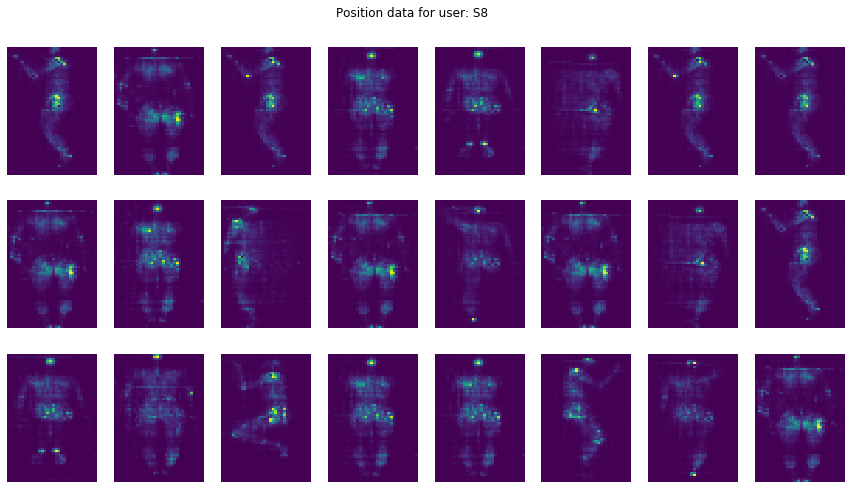

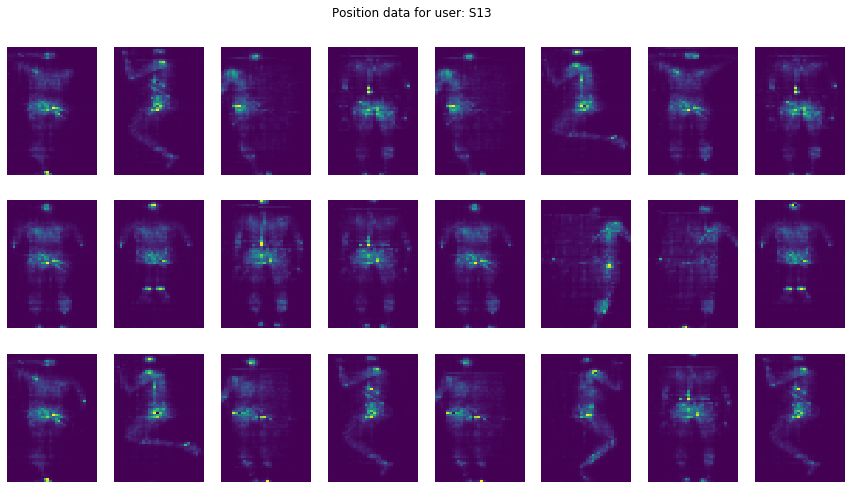

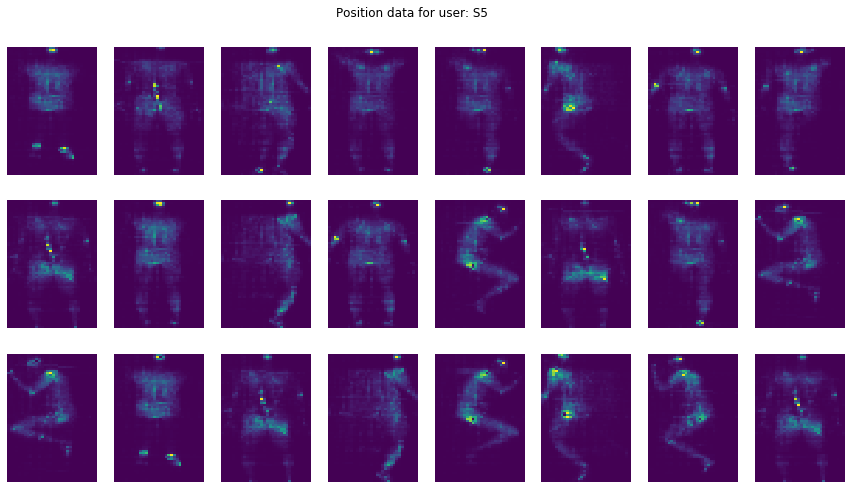

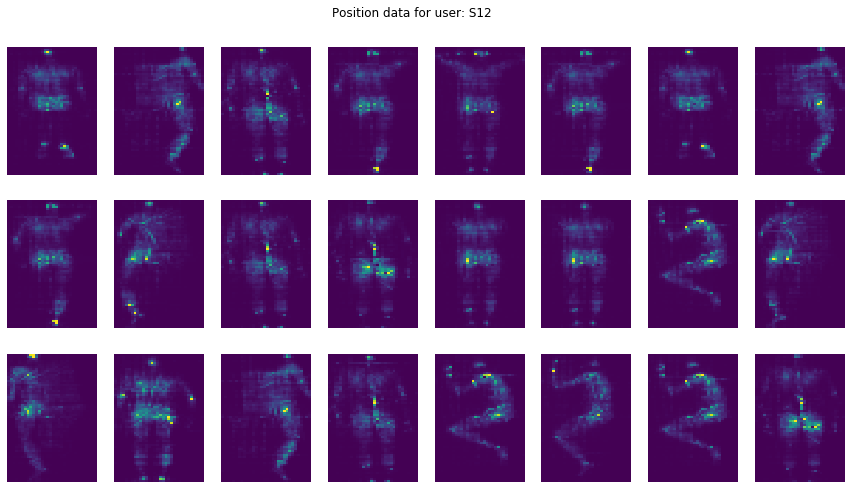

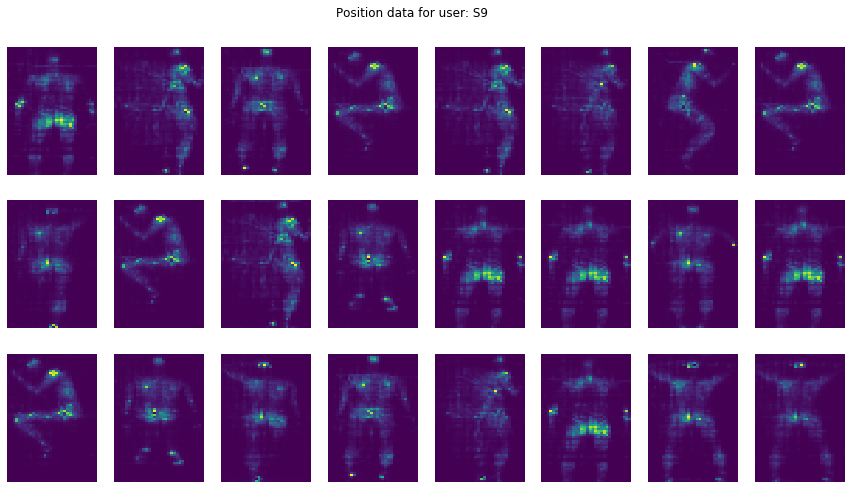

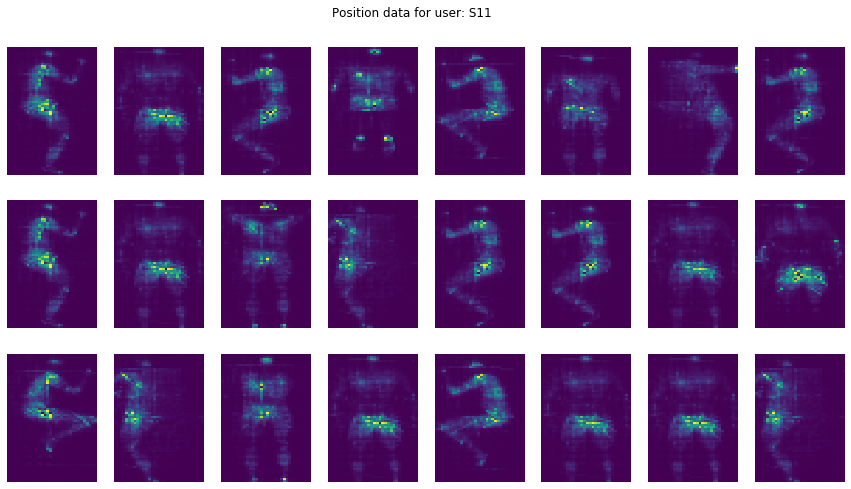

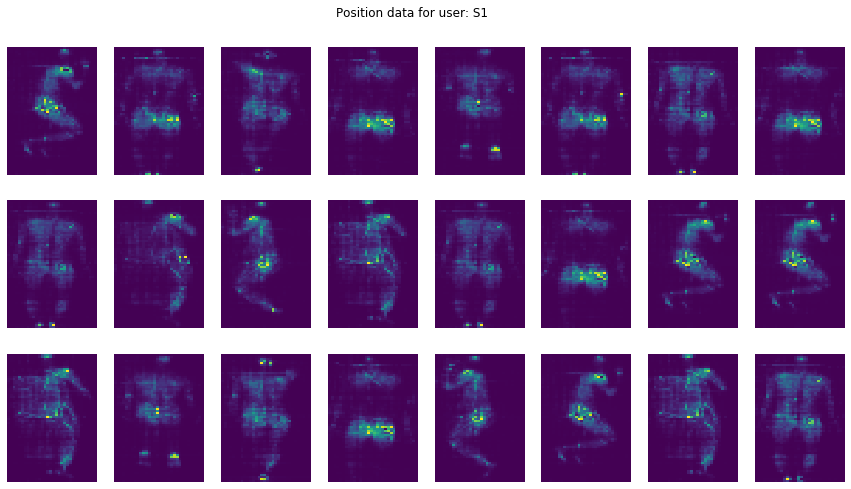

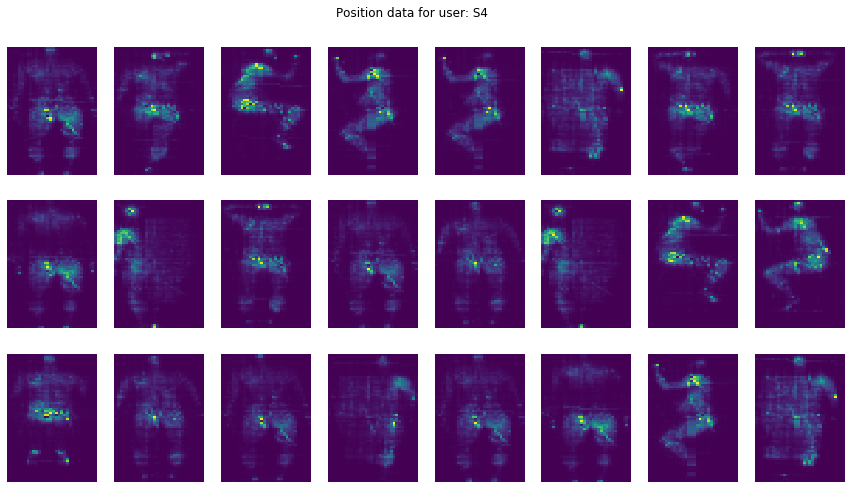

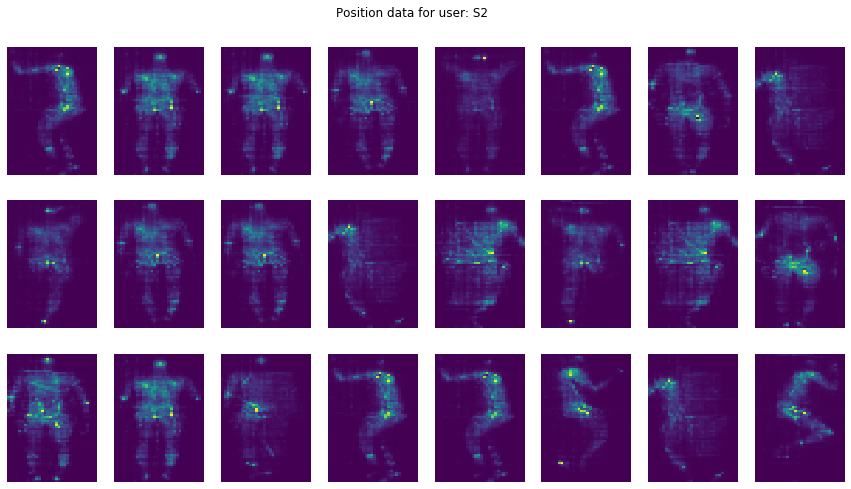

In [14]:
for user in users:
    plot_data01(user, subjects_dict)

After observing the data, it seems that some samples have a degree of noise. This could be due to diverse factors. Also, we can see that for each individual, we have a set of positions, which were recorded using a sensor. In the following sections, we will implement a shallow model to learn from this data.

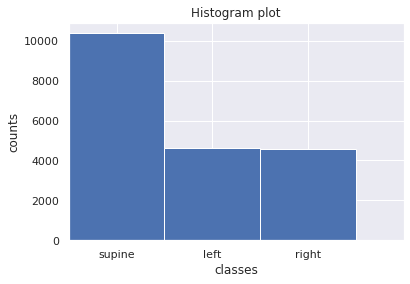

In [26]:
hist_plot01(subjects_dict)

As we can see, the __supine__ posture have the majority in the data set.

## Experiment II

In [15]:
# set path
path = './dataset/experiment-ii/'

In [16]:
# read users
users = users = os.listdir(path)
# remove cvs file
users = users[:5] + users[6:]

In [17]:
# print users
for u in users:
    print(u, end = ' ')

S7 S3 S6 S8 S5 S1 S4 S2 

In [18]:
# load data
subjects_dict_air, subjects_dict_spo = load_data02(path)

In [19]:
beds = ['Air Mat', 'Sponge Mat']

## Air Mat

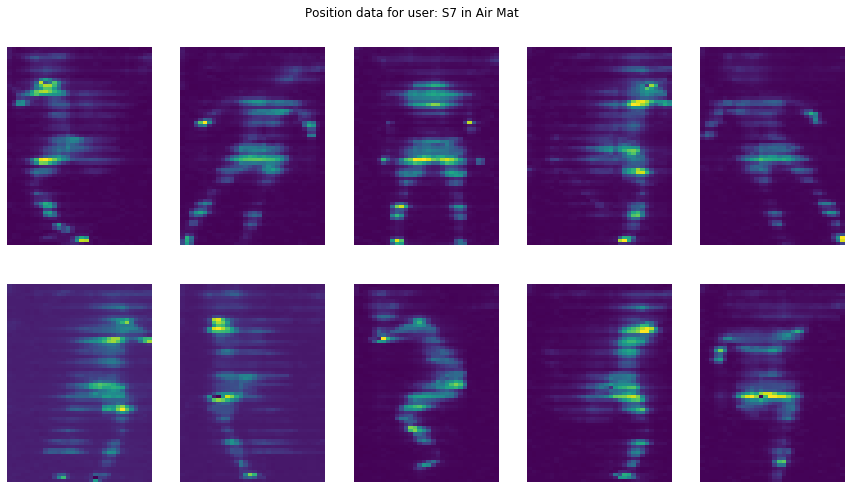

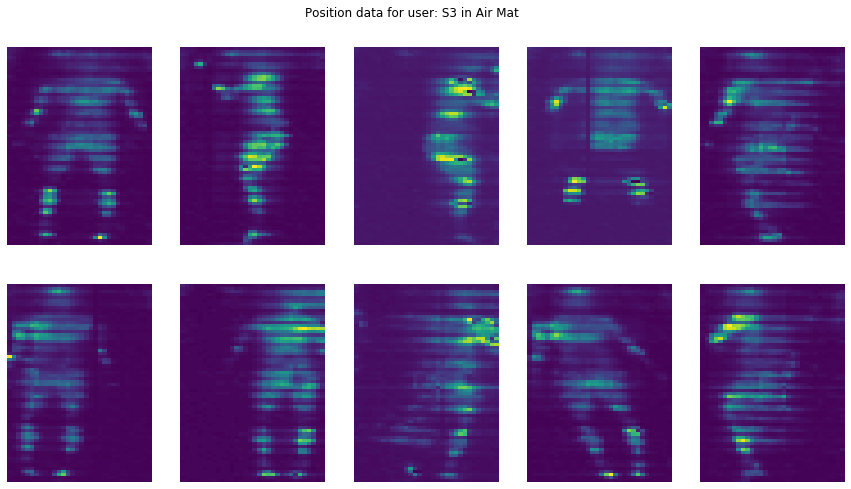

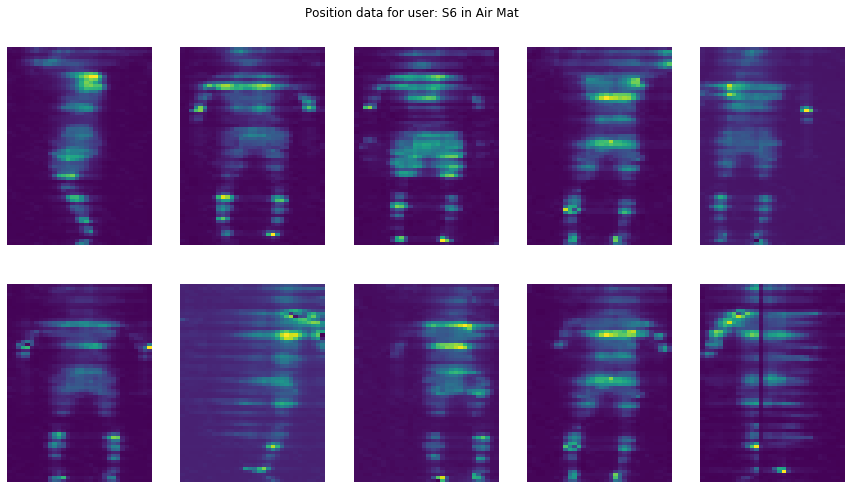

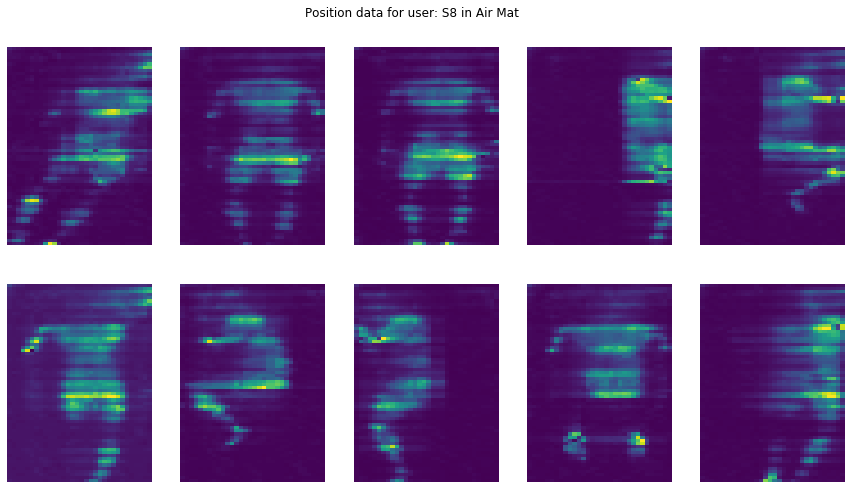

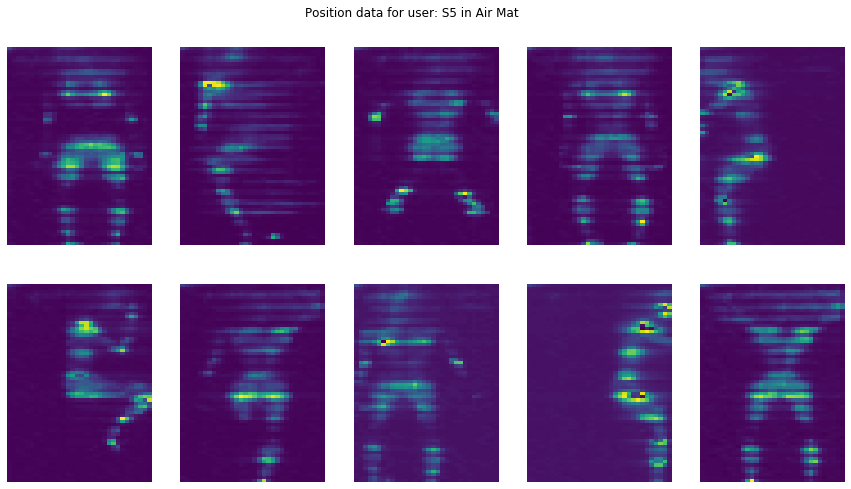

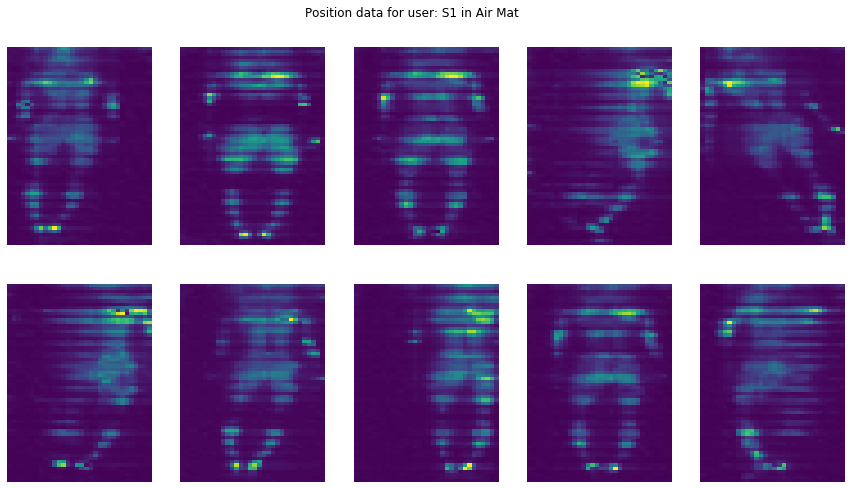

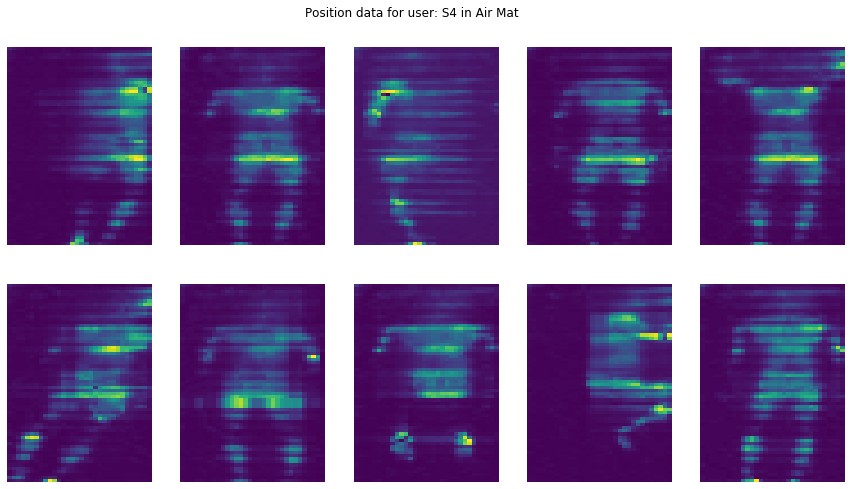

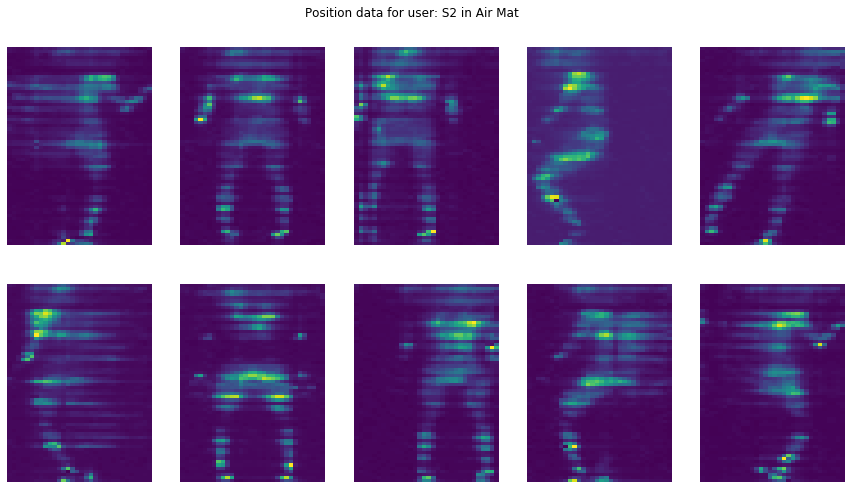

In [20]:
for user in users:
    plot_data02(user, subjects_dict_air, beds[0])

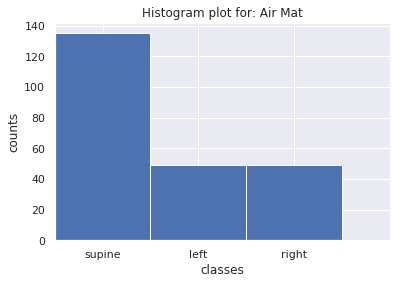

In [74]:
hist_plot02(subjects_dict_air, beds[0])

As we can see, this data set have the __supine__ class as its majority one.

## Sponge Mat

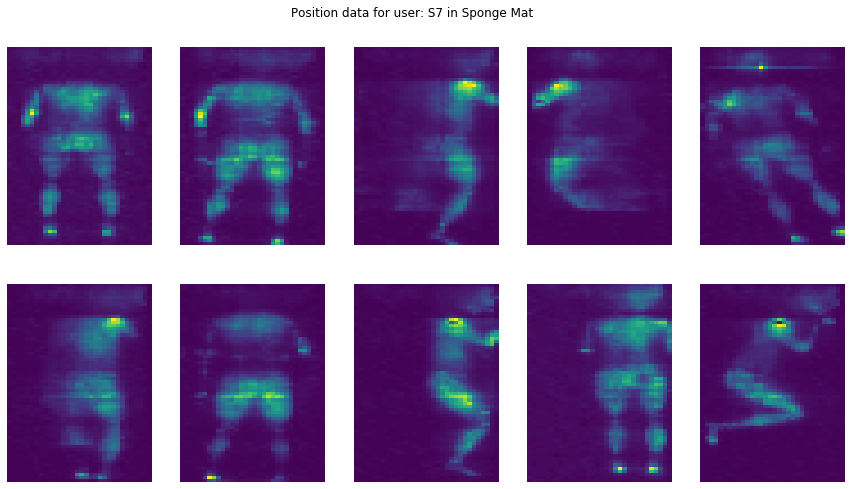

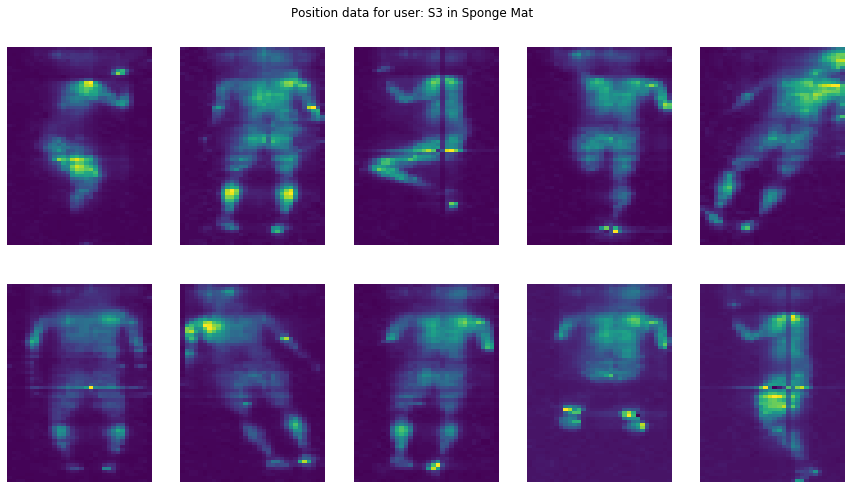

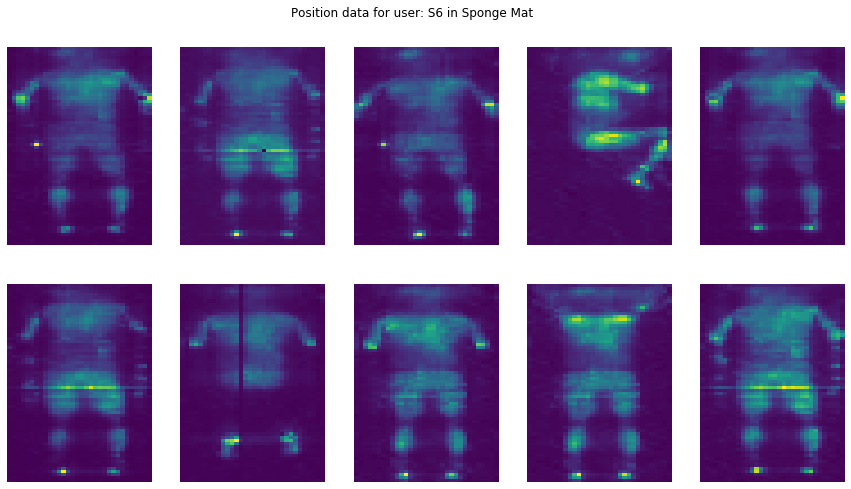

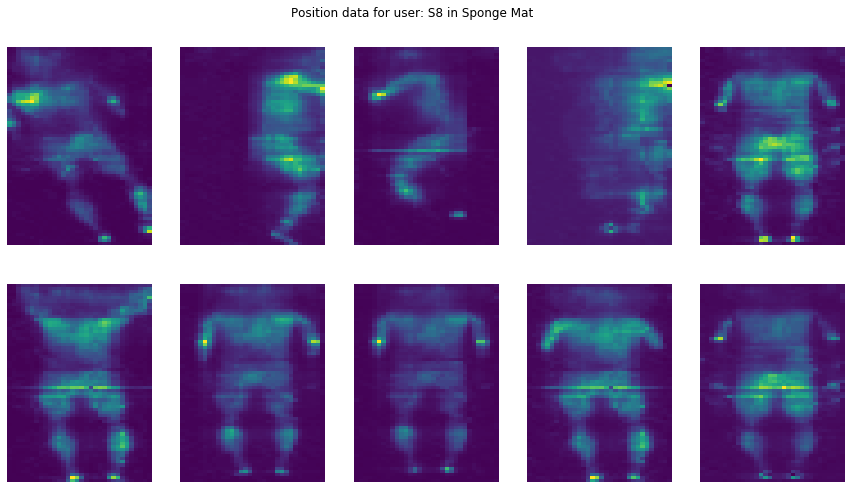

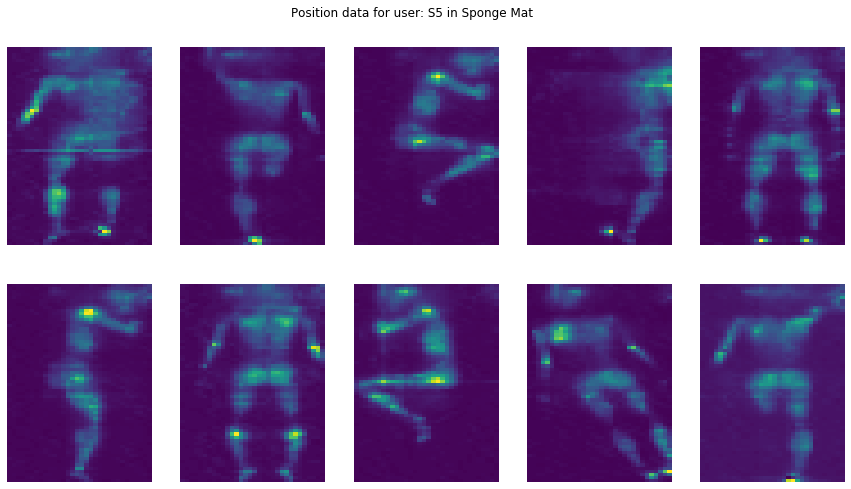

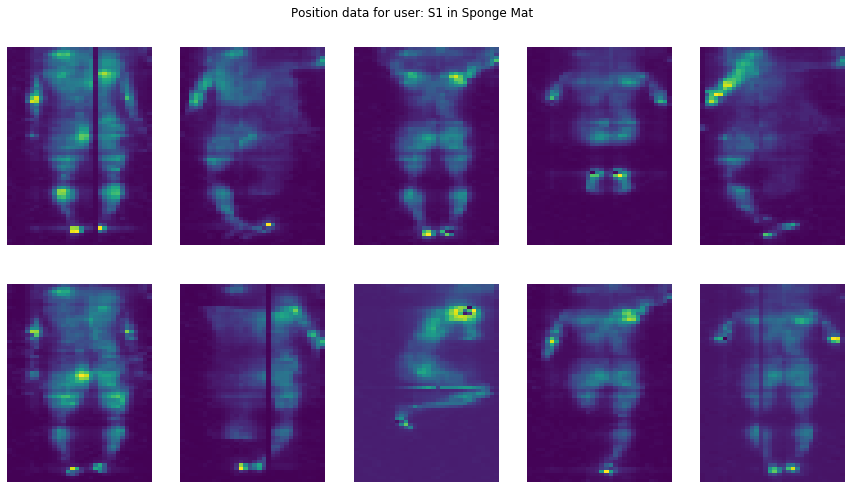

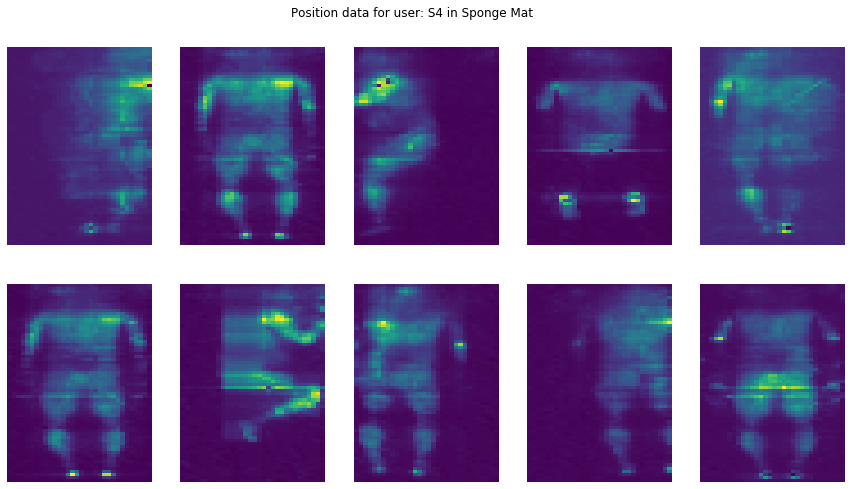

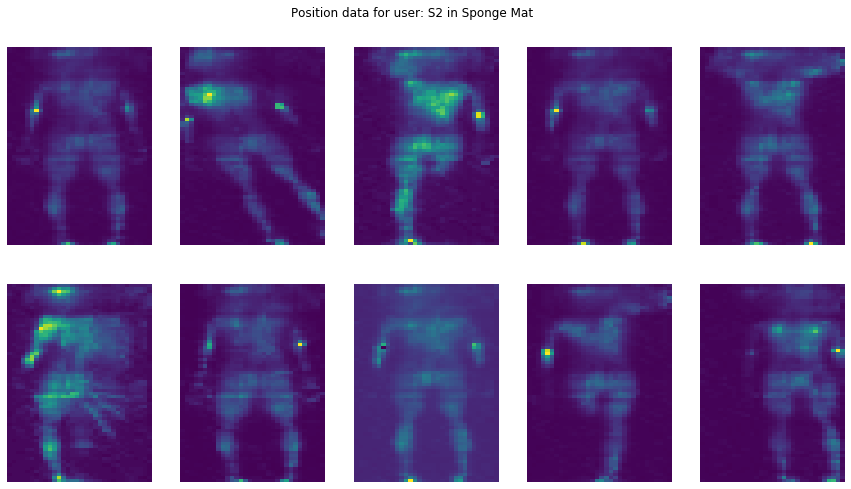

In [21]:
for user in users:
    plot_data02(user, subjects_dict_spo, beds[1])

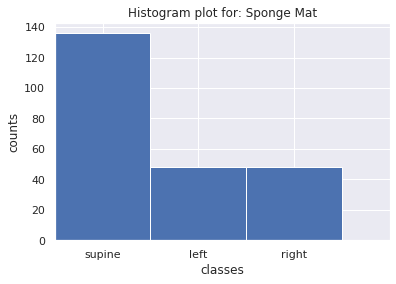

In [73]:
hist_plot02(subjects_dict_spo, beds[1])

As we can see, this data set have the __supine__ class as its majority one.

# Training a Shallow Model on Experiment I data

## Loading the data

In [78]:
path = './dataset/experiment-i/'
# load data
subjects_dict = load_data01(path)
data, labels = create_numpy_data(subjects_dict)

In [79]:
# set training percentage
train_percent = 0.8
train_size = int(train_percent * data.shape[0])

In [80]:
# generate train - test splits
dataset_size = data.shape[0]
indices = list(range(dataset_size))
split = train_size
train_indices, test_indices = indices[:split], indices[split:]

In [81]:
# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
# convert to tensor
dataset = torch.utils.data.TensorDataset(torch.from_numpy(data).float() , torch.from_numpy(labels).long())
# loaders, shuffle is set to false, since we are using SubsetRandomSampler
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = False,
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = False,
                                                sampler=test_sampler)

## Model

In [124]:
class ShallowNet(nn.Module):
    """
    Shallow model, composed by four layers.
    """
    def __init__(self, n_inputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, 150)
        self.fc2 = nn.Linear(150, 150)
        self.output = nn.Linear(150, 3)
        
    def forward(self, x):      
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.output(x), dim = 1)

## Training

In [129]:
# instanciate model
model = ShallowNet(2048)
model

ShallowNet(
  (fc1): Linear(in_features=2048, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=150, bias=True)
  (output): Linear(in_features=150, out_features=3, bias=True)
)

In [130]:
# Set model hyper-parameters
model_optimizer=optim.SGD(model.parameters(),lr=0.01)
# criterion
criterion = nn.NLLLoss()

In [131]:
# set data loaders
loaders = [train_loader, test_loader]

In [132]:
# training
n_epochs = 20
model, train_losses, test_losses = train_model(model, loaders, model_optimizer, criterion, n_epochs, print_epoch=True)

Epoch: 1|20 | Training loss: 1.0278723488048631 | Test loss: 0.9602472705225791 | Test accuracy: 0.5523224472999573
Epoch: 2|20 | Training loss: 0.9044239540489353 | Test loss: 0.8233340296053118 | Test accuracy: 0.5729101896286011
Epoch: 3|20 | Training loss: 0.6790790201449881 | Test loss: 0.6071370676640542 | Test accuracy: 0.8090299367904663
Epoch: 4|20 | Training loss: 0.4165914090312257 | Test loss: 0.40920290975801404 | Test accuracy: 0.8972355723381042
Epoch: 5|20 | Training loss: 0.21786225818249644 | Test loss: 0.26413672609675315 | Test accuracy: 0.921138346195221
Epoch: 6|20 | Training loss: 0.11180401648185691 | Test loss: 0.19643255323171616 | Test accuracy: 0.9309669733047485
Epoch: 7|20 | Training loss: 0.0662448724085579 | Test loss: 0.16049395081016324 | Test accuracy: 0.9344757795333862
Epoch: 8|20 | Training loss: 0.04462703104530062 | Test loss: 0.143852862138902 | Test accuracy: 0.9330024719238281
Epoch: 9|20 | Training loss: 0.03283803529125087 | Test loss: 0.134

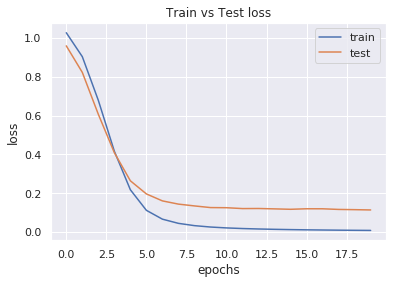

In [133]:
plot_losses(train_losses, test_losses, n_epochs)

## Conclusions
In this notebook, we have perform a basic EDA over the data set. In the first section we focused in the first subset of data, which contains bed postures records. In this subset, the class __supine__ have a major number of instances in contrast with the other two classes. Also, the data present a __slight degree of noise__. For example, the first two rows had noise. This noise correspond to the instance, where the user is positioning on the bed. Meanwhile, for the second subset, we have two different mats (air and sponge). The data in both mats present a more strong degree of noise in comparison with the first subset. Also, we observed a significant __variation in the postures__. This variations added a rotation degree to the basic posture. For example, we have a supine posture with a 45 degree rotation. In both cases (air and sponge), the majority class was: supine. For this subset, there are __less samples__ in contrast with the first one. Finally, we have trained a shallow model. The model achieve a good accuracy. However, since we are dealing with images, a convolutional model could perform better. Because this model needs more time to train.